# Business Context

Cardio Catch Disease is a company specialized in detecting cardiac diseases at early stages.

- **Business Model:** The price of the diagnosis varies according to the accuracy achieved by the team of specialists, the client pays R$500 for each 5% accuracy above 50%.


- **Actual Scenario:** The current diagnostic accuracy varies between 55% and 65%, due to the complexity of the diagnosis, at a cost of R$1000.


- **Main Goal:** Create a disease diagnosis tool with stable accuracy. 


- **Secundary Goals:** Delivery a report ansewirng the follow questions:
    1. How accurate and precise is the tool?
    2. How much profit Cardio Catch Diseases will make with the new tool?
    3. How reliable are the results given by the new tool?
    

Business Project reference: https://sejaumdatascientist.com/projeto-de-data-science-diagnostico-precoce-de-doencas-cardiovasculares/

Data Source: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset

# 0.0. Imports

In [1]:
# data manipulation
import numpy as np
import pandas as pd

# statistics
from scipy.stats import chi2_contingency

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# load images
from IPython.display import Image

# stratified sampling
from sklearn import model_selection as ms

# machine learning models
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, fbeta_score, roc_curve
from sklearn.model_selection import cross_validate

## 0.1. Auxiliar Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    rcorr = r - ((r-1)**2)/(n-1)
    
    kcorr = k - ((k-1)**2)/(n-1)
    
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.2. Load Data

In [3]:
data_raw = pd.read_csv('../datasets/cardio_train.csv', sep=';')

## 0.3. Split Data into Train and Test

In [4]:
data_train, data_test = ms.train_test_split(data_raw, test_size=0.2, random_state=42)

# 1.0. Data Description

In [5]:
df01 = data_train.copy()

## 1.1. Data Types

In [6]:
df01.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.2. Data Dimensions

In [7]:
print(f'Number of rows: {df01.shape[0]}')
print(f'Number of columns: {df01.shape[1]}')

Number of rows: 56000
Number of columns: 13


## 1.3. Check NA

In [8]:
df01.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.4. Fillout NA
There is no NA in the dataset

## 1.5. Change Data Type

## 1.6. Check Balance Data

In [9]:
df01['cardio'].value_counts(normalize=True)

0    0.500589
1    0.499411
Name: cardio, dtype: float64

## 1.7. Descriptive Analysis

In [10]:
# select numeric attributes
num_attributes = df01[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]

# select categoric attributes (include binary and status attributes)
cat_attributes = df01[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']]

### 1.7.1. Numerical Attributes

In [11]:
# central tendency - mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_ = pd.DataFrame(num_attributes.apply(min)).T
max_ = pd.DataFrame(num_attributes.apply(max)).T
range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# join dataframes
num_stats = pd.concat([min_, max_, range_, mean, median, skew, kurtosis]).T.reset_index()
num_stats.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'skew', 'kurtosis']

# display numerical analysis
num_stats

,attributes,min,max,range,mean,median,skew,kurtosis
0,age,10798.0,23713.0,12915.0,19464.929107,19699.0,-0.305523,-0.823461
1,height,55.0,250.0,195.0,164.348125,165.0,-0.594831,7.616794
2,weight,22.0,200.0,178.0,74.188586,72.0,1.015661,2.630229
3,ap_hi,-140.0,14020.0,14160.0,128.737893,120.0,85.641414,7642.334178
4,ap_lo,0.0,11000.0,11000.0,97.025536,80.0,31.969044,1369.195570


### 1.7.2. Categorical Attributes

In [12]:
cat_attributes.astype('object').describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio
count,56000,56000,56000,56000,56000,56000,56000
unique,2,3,3,2,2,2,2
top,1,1,1,0,0,1,0
freq,36401,41910,47619,51030,52929,45011,28033


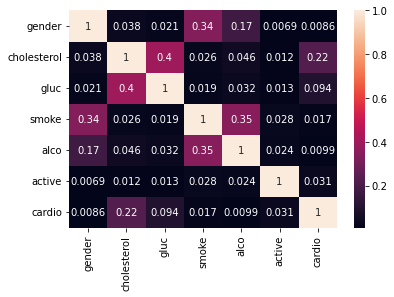

In [13]:
cat_columns = cat_attributes.columns.tolist()

corr_dict = {}

for main_cols in cat_columns:
    corr_list = []
    
    for secundary_cols in cat_columns:
        #cramer v
        cat_corr = cramer_v(cat_attributes[main_cols], cat_attributes[secundary_cols])
        
        # add to list
        corr_list.append(cat_corr)
    
    # add to dict each attribute correlation
    corr_dict[main_cols] = corr_list
    
df_corr = pd.DataFrame(corr_dict)
df_corr = df_corr.set_index(df_corr.columns)
sns.heatmap(df_corr, annot=True);

# 2.0. Feature Engineering

In [14]:
df02 = df01.copy()

## 2.1. Mental Map of Hypothesis

In [15]:
Image('../images/CARDIO_CATCH_DESEASE.png')

FileNotFoundError: No such file or directory: '../images/CARDIO_CATCH_DESEASE.png'

FileNotFoundError: No such file or directory: '../images/CARDIO_CATCH_DESEASE.png'

<IPython.core.display.Image object>

## 2.2. Hypothesis Creation

### 2.2.1. Objective Features Hypotheses

1. Ambos os gêneros possuem a mesma proporção de doenças cardiovasculares..

2. Pessoas com mais de 40 anos possuem mais que o dobro de doenças cardiovasculares, em média.

3. Quanto maior a relação de peso/altura maior a quantidade de doenças cardiovasculares.

4. Entre 40% e 50% das pessoas acima de 100kg possuem doenças cardiovasculares.

5. Pessoas com alturas abaixo de 150cm possuem metade de doenças cardiovasculares em média.


### 2.2.2. Examination Features Hypotheses

1. Pessoas com colesterol muito acima do normal possuem o dobro de doenças cardiovasculares, em média.

2. Menos de 25% das pessoas com colesterol e glucose normal possuem doenças cardiovasculares.

3. Pessoas com os três niveis de glucose possuem uma porcentagem semelhante (+/-5%) de doenças cardiovasculares.

4. Pessoas com pressão systolic acima de 120mmHg possuem 50% a mais de doenças cardiovasculares comparadas as com pressão abaixo.

5. Pessoas com pressão diastolic acima de 80mmHg possuem 50% a mais de doenças cardiovasculares comparadas as com pressão abaixo. 

6. Pessoas com a pressão arterial (ap_hi / api_lo) maior que 2 possuem 30% mais doenças cardiovasculares do que as com pressão abaixo. 


### 2.2.3. Subjective Features Hypotheses

1. Pessoas que bebem possuem 20% menos doenças cardiovasculares, em média.

2. Pessoas que praticam atividade física possuem 30% menos doenças cardiovasculares, em média.

3. Pessoas que fumam, bebem e não praticam exercicio físico possuem 3 vezes mais doenças cardiovasculares em média.

4. Pessoas que fumam possuem um porcentagem semelhante (+/-5%) de deonças cardiovasculares comparadas as que não fumam.

5. Pessoas que bebem e praticam exercico fisico possuem 50% menos doenças cardiovasculares comparadas as que não, em média.

## 2.3. Final Hypothesis List

1. Ambos os gêneros possuem a mesma proporção de doenças cardiovasculares..

2. Pessoas com mais de 40 anos possuem mais que o dobro de doenças cardiovasculares, em média.

3. Quanto maior a relação de peso/altura maior a quantidade de doenças cardiovasculares.

4. Entre 40% e 50% das pessoas acima de 100kg possuem doenças cardiovasculares.

5. Pessoas com alturas abaixo de 150cm possuem metade de doenças cardiovasculares em média.

6. Pessoas com colesterol muito acima do normal possuem o dobro de doenças cardiovasculares, em média.

7. Menos de 25% das pessoas com colesterol e glucose normal possuem doenças cardiovasculares.

8. Pessoas com os três niveis de glucose possuem uma porcentagem semelhante (+/-5%) de doenças cardiovasculares.

9. Pessoas com pressão systolic acima de 120mmHg possuem 50% a mais de doenças cardiovasculares comparadas as com pressão abaixo.

10. Pessoas com pressão diastolic acima de 80mmHg possuem 50% a mais de doenças cardiovasculares comparadas as com pressão abaixo. 

11. Pessoas com a pressão arterial (ap_hi / api_lo) maior que 2 possuem 30% mais doenças cardiovasculares do que as com pressão abaixo. 

12. Pessoas que bebem possuem 20% menos doenças cardiovasculares, em média.

13. Pessoas que praticam atividade física possuem 30% menos doenças cardiovasculares, em média.

14. Pessoas que fumam, bebem e não praticam exercicio físico possuem 3 vezes mais doenças cardiovasculares em média.

15. Pessoas que fumam possuem um porcentagem semelhante (+/-5%) de deonças cardiovasculares comparadas as que não fumam.

16. Pessoas que bebem e praticam exercico fisico possuem 50% menos doenças cardiovasculares comparadas as que não, em média.

# 3.0. Data Filtering

In [16]:
df03 = df02.copy()

## 3.1. Filtering Rows

## 3.2. Columns Selection

# 4.0. Exploratory Data Analysis

In [17]:
df04 = df03.copy()

# 5.0. Data Preparation

In [18]:
df05 = df04.copy()

# 6.0. Feature Selection

In [19]:
df06 = df05.copy()

## 6.1. Split Dataframe into Training and Validation Dataset

In [20]:
# features dataset
X = df06.drop(['cardio'],axis=1)

# response dataset
y = df06['cardio']

In [21]:
# split dataset into training  and validation
X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)

# 7.0. Machine Learning Model

**References:**

- Evaluation Metrics for Evaluation Models: https://neptune.ai/blog/evaluation-metrics-binary-classification#:~:text=Simply%20put%20a%20classification%20metric,to%20classes%3A%20positive%20and%20negative.

In [22]:
# select data for machine learning models
x_train = X_train.copy()
x_val = X_val.copy()

## 7.1. Random Forest Classifier 

In [23]:
# model definition
model_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1).fit(x_train, y_train)

### 7.1.1. Random Forest Classifier - Performance

In [24]:
# prediction
pred_rf = model_rf.predict(x_val)

# evaluate performance of model
rf_performance = pd.DataFrame(['Random Forest Classifier',
                               accuracy_score(y_val, pred_rf), 
                               precision_score(y_val, pred_rf), 
                               recall_score(y_val, pred_rf), 
                               f1_score(y_val, pred_rf),
                               roc_auc_score(y_val, pred_rf)]).T

# set metris as columns name
rf_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# display performance
rf_performance

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest Classifier,0.7275,0.746399,0.696745,0.720717,0.727788


### 7.1.2. Random Forest Classifier - Cross-Validation

In [25]:
# select metrics of interest
metrics = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')

# cross validation of model
scores  = cross_validate(model_rf, x_train, y_train, scoring=metrics, cv=10)

# cross validation accuracy
acc_cv_mean = np.round(scores['test_accuracy'].mean(), 6)
acc_cv_std = np.round(scores['test_accuracy'].std(), 6)

# cross validation precision
prec_cv_mean = np.round(scores['test_precision'].mean(), 6)
prec_cv_std = np.round(scores['test_precision'].std(), 6)

# cross validation recall
recall_cv_mean = np.round(scores['test_recall'].mean(), 6)
recall_cv_std = np.round(scores['test_recall'].std(), 6)

# cross validation F1 score
f1_score_cv_mean = np.round(scores['test_f1'].mean(), 6)
f1_score_cv_std = np.round(scores['test_f1'].std(), 6)

# cross validation ROC-AUC
roc_auc_cv_mean = np.round(scores['test_roc_auc'].mean(), 6)
roc_auc_cv_std = np.round(scores['test_roc_auc'].std(), 6)

# calculate mean and std and build dataframe for each metric
rf_performance_cv = pd.DataFrame({'Model': 'Random Forest Classifier', 
                                  'Accuracy': f'{acc_cv_mean} +/- {acc_cv_std}', 
                                  'Precision': f'{prec_cv_mean} +/- {prec_cv_std}', 
                                  'Recall': f'{recall_cv_mean} +/- {recall_cv_std}', 
                                  'F1 Score': f'{f1_score_cv_mean} +/- {f1_score_cv_std}', 
                                  'ROC AUC': f'{roc_auc_cv_mean} +/- {roc_auc_cv_std}'}, 
                                  index=[0])

# display model perfomance
rf_performance_cv

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest Classifier,0.721875 +/- 0.004304,0.734103 +/- 0.006571,0.692584 +/- 0.006631,0.712702 +/- 0.004161,0.78358 +/- 0.005899


In [26]:
f2 = fbeta_score(y_val, pred_rf, beta = 2)

f2

0.7061397217042031